In [94]:
import os
pwd = os.getcwd()

In [95]:
import sys
sys.path.append(os.path.join(pwd, '..', '..'))

In [96]:
from server.utils import load_config

In [97]:
conf_dir = os.path.abspath(os.path.join(pwd, '..', '..', 'config', 'base.yaml'))
config = load_config(conf_dir)

In [98]:
from server import db
from sqlalchemy.orm import sessionmaker
import json

In [99]:
engine = db.sync_engine(config['postgres'])
Session = sessionmaker(bind=engine)
session = Session()

In [129]:
from sqlalchemy.orm.exc import NoResultFound

cursor = session.query(db.order).filter(
    (db.order.c.extra['is_finished'].astext == '0')
    & (db.order.c.pub_date > '2017-03-25')

)
rate = session.query(db.history).filter(
    db.order.c.pub_date > '2017-03-25'
)
def as_dict(row):
    item = row._asdict().copy()
    item['api'] = json.loads(item['api'])
    return item

def iter_tail(item, tail):
    try:
        next_step = session.query(db.order).filter(
            db.order.c.extra['next'].astext == str(item['id'])
        ).one()
    except NoResultFound:
        next_step = False
        
    if next_step:
        next_step_item = as_dict(next_step)
        tail.append(next_step_item)
        iter_tail(next_step_item, tail)
    return tail

In [130]:
thread_list = []
for order in cursor:
    item = as_dict(order)
    tail = [item]
    iter_tail(item, tail)
    thread_list.append(tail)

In [131]:
import matplotlib.pyplot as plt

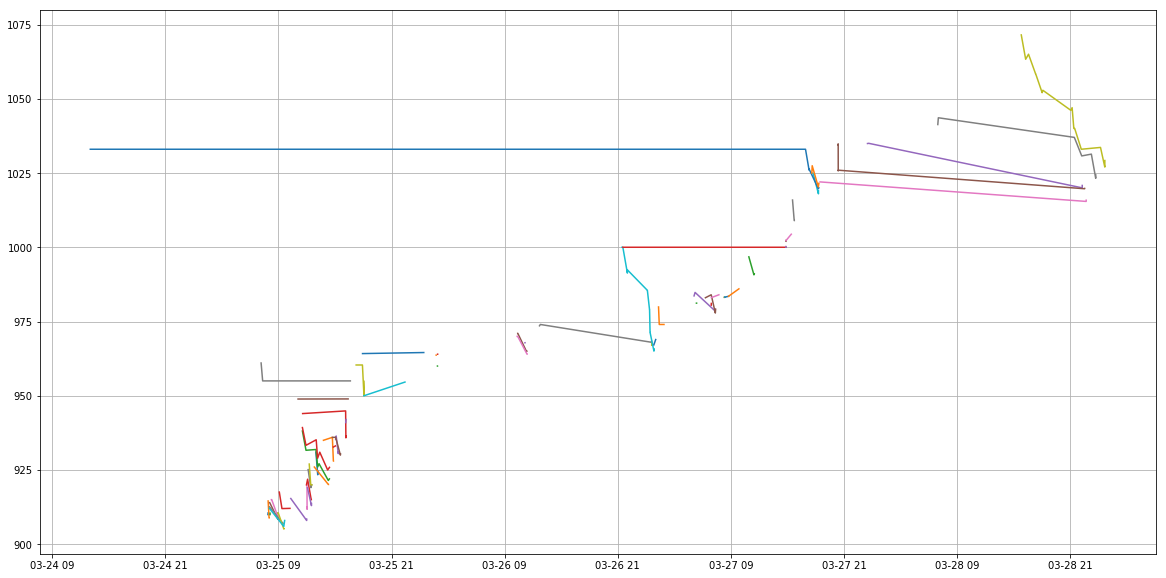

In [132]:
fig, ax1 = plt.subplots()
fig(figsize=(20,10))
plt.grid(True)
for thread in thread_list:
    ax1.plot(list(map(lambda i: i['pub_date'], thread)), list(map(lambda i: i['price'], thread)))
    
plt.show()